In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange
import warnings
from scipy import sparse
import itertools
from scipy.optimize import curve_fit
warnings.filterwarnings("ignore")
from scipy.stats import kstest
from scipy.stats import pareto
from scipy.stats import pearsonr
from math import e

from sklearn.linear_model import LinearRegression as linreg

In [2]:
lambdas = [2, 1]
mu = 1
epsilon = [0.1, 0.01, 0.001, 0.0001]
N = 10**4

# CRACKLING NOISE

In [3]:
l = 2

In [4]:
def my_pareto(x, a,b):
    return a*np.power(x,-b)

In [5]:
def my_line(x, a, b):
    return a - b*x

In [6]:
def cnr(alpha, dalpha, tau, dtau):
    gamma = (alpha - 1)/(tau -1)
    dgamma = np.sqrt(dalpha**2/(tau - 1)**2 + (dtau**2)*((alpha - 1)**2)/(tau - 1)**4)
    return gamma, dgamma

In [7]:
def optimal_n(size):
    #return int(np.ceil(2*(len(size))**(2/5))) #wikipedia
    return int((len(sizes))**(1/3))

## $\epsilon$ = 0.0001

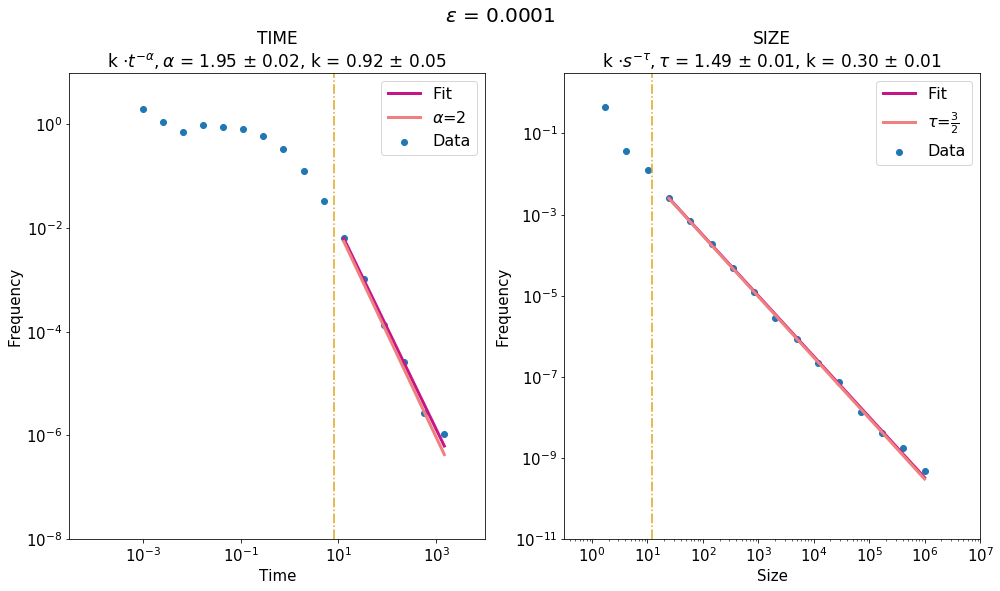

In [8]:
eps = 0.0001

sizes = np.load("final_size_"+str(eps)+"_"+str(l)+".npy")
sizes.sort()
times = np.load("final_time_"+str(eps)+"_"+str(l)+".npy")
times.sort()

n_t_bins = optimal_n(times) #<------PARAMETER
threshold_t = 8  #<------PARAMETER
n_s_bins = optimal_n(sizes)  #<------PARAMETER
threshold_s = 12  #<------PARAMETER

fig, (ax1, ax) = plt.subplots(1,2, figsize=(14,8))
fig.suptitle(r"$\epsilon$ = %.4f"%(eps), y=1.02, fontsize=20)

#TIMES

#binning

bins_t = np.logspace(np.log10(np.min(times)),np.log10(np.max(times+1)),n_t_bins)
#compute NORMALIZED binning error as ~ sqrt(counts)/nom_cost with norm_cos= sum(counts*bin_width)
y_times, bins_t = np.histogram(times, bins=bins_t)
bin_widths = [bins_t[i+1]-bins_t[i] for i in range(len(bins_t)-1)]
y_times_err = np.sqrt(y_times)/np.sum(y_times*bin_widths)

y_times, bins_t = np.histogram(times, bins=bins_t, density=True)
x_times = [bins_t[i]+0.5*(bins_t[i+1]-bins_t[i]) for i in range(len(bins_t)-1)]
x_times=np.array(x_times)

#plot data
ax1.scatter(x_times, y_times, marker ="o", label="Data")
#ax1.errorbar(x_times, y_times, y_times_err, linestyle="None")
ax1.axvline(x=threshold_t, color="goldenrod", linestyle="-.")

#filter data to be fitted and fit

filter_t = np.argwhere(x_times > threshold_t).flatten()
x_times_f = x_times[filter_t]
y_times_f = y_times[filter_t]
y_times_err = y_times_err[filter_t]
(k_t, alpha), pcov_t = curve_fit(my_pareto, x_times_f, y_times_f, sigma=y_times_err, p0=(1, 2))
dalpha = np.sqrt(pcov_t[1][1])

#plot result of the fit
ax1.plot(x_times_f, my_pareto(x_times_f, k_t, alpha), color="mediumvioletred", linewidth=3, label="Fit")
ax1.plot(x_times_f, my_pareto(x_times_f, k_t, 2), color="lightcoral", linewidth=3, label=r"$\alpha$=2")
ax1.set_xlabel("Time", fontsize=15)
ax1.set_ylabel("Frequency", fontsize=15)
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylim(10**(-8),10**1)
ax1.set_xlim(10**(-4.5), 10**4)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_title("TIME\n"+r"k $\cdot t^{-\alpha}, \alpha$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %(alpha, dalpha, k_t, np.sqrt(pcov_t[0][0])), fontsize=17)
ax1.legend(fontsize=16)



#SIZES
bins_s = np.logspace(np.log10(np.min(sizes)),np.log10(np.max(sizes+1)),n_s_bins)
#compute binning errors
y_sizes, bins_s = np.histogram(sizes, bins=bins_s)
bin_widths = [bins_s[i+1]-bins_s[i] for i in range(len(bins_s)-1)]
y_sizes_err = np.sqrt(y_sizes)/np.sum(y_sizes*bin_widths)

#binning
y_sizes, bins_s = np.histogram(sizes, bins=bins_s, density=True)
x_sizes = [bins_s[i]+0.5*(bins_s[i+1]-bins_s[i]) for i in range(len(bins_s)-1)]
x_sizes= np.array(x_sizes)

#plot data
ax.scatter(x_sizes, y_sizes, marker ="o", label="Data")
#ax.errorbar(x_sizes, y_sizes, y_sizes_err, linestyle="None")
ax.axvline(x=threshold_s, color="goldenrod", linestyle="-.")

#filter data to be fitted and fit

filter_s = np.argwhere(x_sizes > threshold_s).flatten()
x_sizes_f = x_sizes[filter_s]
y_sizes_f = y_sizes[filter_s]
y_sizes_err = y_sizes_err[filter_s]
(k_s, tau), pcov_s = curve_fit(my_pareto, x_sizes_f, y_sizes_f, sigma=y_sizes_err, p0=(1, 1.5))
dtau = np.sqrt(pcov_s[1][1])
#plot result of the fit
ax.plot(x_sizes_f, my_pareto(x_sizes_f, k_s, tau), color="mediumvioletred", linewidth=3, label="Fit")
ax.plot(x_sizes_f, my_pareto(x_sizes_f, k_s, 1.5), color="lightcoral", linewidth=3, label=r"$\tau$=$\frac{3}{2}$")
ax.set_xlabel("Size", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(10**(-11),10**0.5)
ax.set_xlim(10**(-0.5),10**7)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title("SIZE\n"+r"k $\cdot s^{-\tau}, \tau$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %(tau, dtau, k_s, np.sqrt(pcov_s[0][0])), fontsize=17)
ax.legend(fontsize=16)



fig.tight_layout()



In [9]:
(_, alpha_lf), pcov_t = curve_fit(my_line, np.log10(x_times_f), np.log10(y_times_f), 
                               sigma=np.log10(e)*y_times_err/y_times_f, p0=(1, 2))
print("Result of linear fit: alpha = %.4f \pm %.4f" %(alpha_lf, pcov_t[1][1]))
print("Result of pareto fir: alpha = %.4f \pm %.4f" %(alpha, dalpha))

(_, tau_lf), pcov_s = curve_fit(my_line, np.log10(x_sizes_f), np.log10(y_sizes_f), 
                               sigma=np.log10(e)*y_sizes_err/y_sizes_f, p0=(1, 1.5))
print("Result of linear fit: tau = %.4f \pm %.4f" %(tau_lf, pcov_t[1][1]))
print("Result of pareto fit: tau = %.4f \pm %.4f" %(tau, dtau))

Result of linear fit: alpha = 1.9427 \pm 0.0005
Result of pareto fir: alpha = 1.9478 \pm 0.0225
Result of linear fit: tau = 1.4934 \pm 0.0005
Result of pareto fit: tau = 1.4941 \pm 0.0052


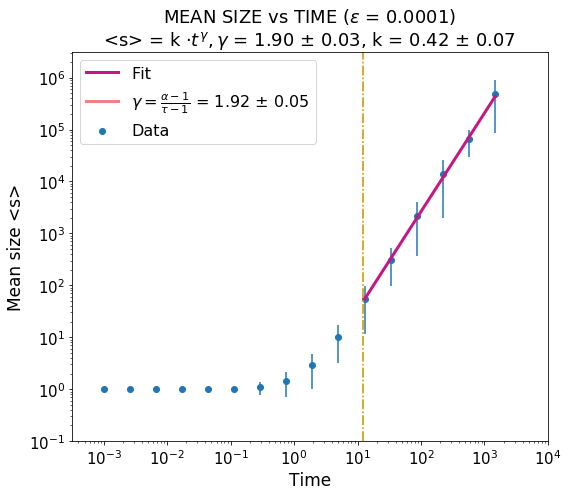

In [10]:
times = np.load("final_time_"+str(eps)+"_"+str(l)+".npy")
sizes = np.load("final_size_"+str(eps)+"_"+str(l)+".npy")


mean_s=[]
std_s=[]
for i in range(n_t_bins - 1):
    in_bin=[]
    for arg_t,t in enumerate(times):
        if t < bins_t[i+1] and t >= bins_t[i]:
            in_bin.append(arg_t)
    mean_s.append(np.mean(sizes[in_bin]))
    std_s.append(np.std(sizes[in_bin]))

    
#delete nanas    
mean_s = np.array(mean_s)
std_s=np.array(std_s)
filter_nanas = ~np.isnan(mean_s)
x_times_f = x_times[filter_nanas]
mean_s = mean_s[filter_nanas]
std_s = std_s[filter_nanas]


fig, ax = plt.subplots(1,1, figsize=(8,7))  

#cut first part of the distribution
ax.scatter(x_times_f, mean_s, marker ="o", label="Data")
ax.errorbar(x_times_f, mean_s, yerr=std_s, linestyle="None")
cut=12
ax.axvline(cut, color="goldenrod", linestyle="-.")
ax.axvline(cut, color="goldenrod", linestyle="-.")
filter_brutti = np.argwhere(x_times_f > cut).flatten()
x_times_f = x_times_f[filter_brutti]
mean_s = mean_s[filter_brutti]
std_s = std_s[filter_brutti]

#fit
(k, gamma), pcov = curve_fit(my_pareto, x_times_f, mean_s, p0=(1, 2), sigma=std_s)

th_gamma, th_d_gamma = cnr(alpha, dalpha, tau, dtau )

ax.plot(x_times_f, my_pareto(x_times_f, k, gamma), color="mediumvioletred", linewidth=3, label="Fit")
ax.plot(x_times_f, my_pareto(x_times_f, k, th_gamma), color="lightcoral", linewidth=3, 
                             label=r"$\gamma = \frac{\alpha -1}{\tau -1}$ = %.2f $\pm$ %.2f"%(th_gamma, th_d_gamma))

ax.set_xlabel("Time", fontsize=17)
ax.set_ylabel("Mean size <s>", fontsize=17)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(10**(-1),10**6.5)
ax.set_xlim(10**(-3.5),10**4)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=16)
ax.set_title("MEAN SIZE vs TIME ($\epsilon$ = %.4f)\n" %eps + r"<s> = k $\cdot t^\gamma, \gamma$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %( -gamma, np.sqrt(pcov[1][1]), k, np.sqrt(pcov[0][0])), fontsize=18)

fig.tight_layout()


In [11]:
print("Perason correlation coeffcient: %.3f"%pearsonr(np.log10(x_times_f), np.log10(mean_s))[0])

Perason correlation coeffcient: 1.000


## $\epsilon$ = 0.001

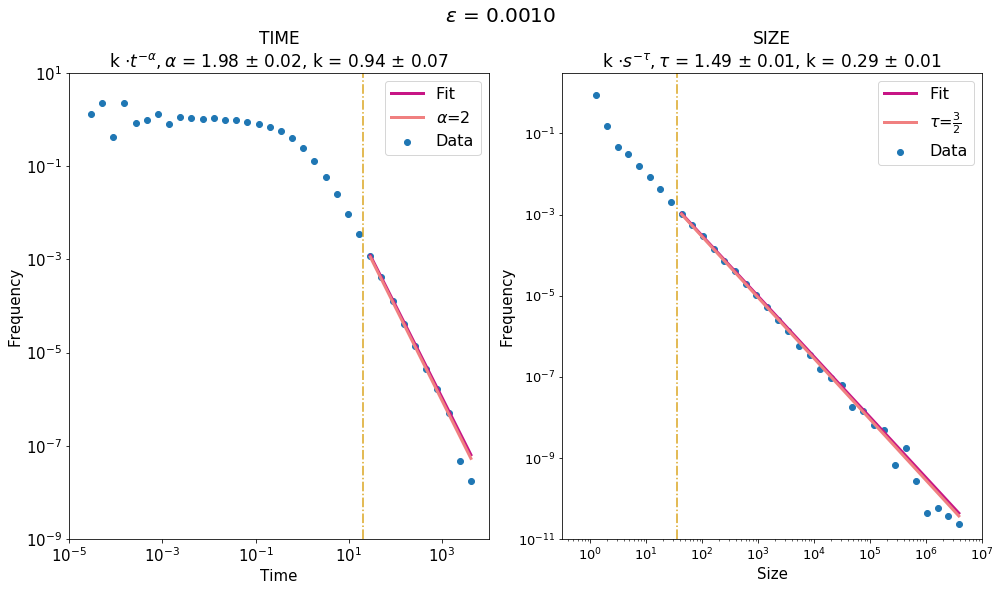

In [12]:
eps = 0.001

sizes = np.load("final_size_"+str(eps)+"_"+str(l)+".npy")
sizes.sort()
times = np.load("final_time_"+str(eps)+"_"+str(l)+".npy")
times.sort()

n_t_bins = optimal_n(times) #<------PARAMETER
threshold_t = 20  #<------PARAMETER
n_s_bins = optimal_n(sizes)  #<------PARAMETER
threshold_s = 35  #<------PARAMETER


fig, (ax1, ax) = plt.subplots(1,2, figsize=(14,8))
fig.suptitle(r"$\epsilon$ = %.4f"%(eps), y=1.02, fontsize=20)

#TIMES


#binning

bins_t = np.logspace(np.log10(np.min(times)),np.log10(np.max(times+1)),n_t_bins)

#compute NORMALIZED binning error as ~ sqrt(counts)/nom_cost with norm_cos= sum(counts*bin_width)
y_times, bins_t = np.histogram(times, bins=bins_t)
bin_widths = [bins_t[i+1]-bins_t[i] for i in range(len(bins_t)-1)]
y_times_err = np.sqrt(y_times)/np.sum(y_times*bin_widths)

y_times, bins_t = np.histogram(times, bins=bins_t, density=True)
x_times = [bins_t[i]+0.5*(bins_t[i+1]-bins_t[i]) for i in range(len(bins_t)-1)]
x_times=np.array(x_times)

#plot data

ax1.scatter(x_times, y_times, marker ="o", label="Data")
#ax1.errorbar(x_times, y_times, y_times_err, linestyle="None")
ax1.axvline(x=threshold_t, color="goldenrod", linestyle="-.")

#filter data to be fitted and fit

filter_t = np.argwhere(x_times > threshold_t).flatten()
x_times_f = x_times[filter_t]
y_times_f = y_times[filter_t]
y_times_err = y_times_err[filter_t]
(k_t, alpha), pcov_t = curve_fit(my_pareto, x_times_f, y_times_f, sigma=y_times_err, p0=(1, 2))
dalpha = np.sqrt(pcov_t[1][1])

#plot result of the fit

ax1.plot(x_times_f, my_pareto(x_times_f, k_t, alpha), color="mediumvioletred", linewidth=3, label="Fit")
ax1.plot(x_times_f, my_pareto(x_times_f, k_t, 2), color="lightcoral", linewidth=3, label=r"$\alpha$=2")
ax1.set_xlabel("Time", fontsize=15)
ax1.set_ylabel("Frequency", fontsize=15)
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylim(10**(-9),10**1)
ax1.set_xlim(10**(-5), 10**4)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_title("TIME\n"+r"k $\cdot t^{-\alpha}, \alpha$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %(alpha, dalpha, k_t, np.sqrt(pcov_t[0][0])), fontsize=17)
ax1.legend(fontsize=16)



#SIZES


bins_s = np.logspace(np.log10(np.min(sizes)),np.log10(np.max(sizes+1)),n_s_bins)

#compute binning errors

y_sizes, bins_s = np.histogram(sizes, bins=bins_s)
bin_widths = [bins_s[i+1]-bins_s[i] for i in range(len(bins_s)-1)]
y_sizes_err = np.sqrt(y_sizes)/np.sum(y_sizes*bin_widths)

#binning

y_sizes, bins_s = np.histogram(sizes, bins=bins_s, density=True)
x_sizes = [bins_s[i]+0.5*(bins_s[i+1]-bins_s[i]) for i in range(len(bins_s)-1)]
x_sizes= np.array(x_sizes)

#plot data

ax.scatter(x_sizes, y_sizes, marker ="o", label="Data")
#ax.errorbar(x_sizes, y_sizes, y_sizes_err, linestyle="None")
ax.axvline(x=threshold_s, color="goldenrod", linestyle="-.")

#filter data to be fitted and fit

filter_s = np.argwhere(x_sizes > threshold_s).flatten()
x_sizes_f = x_sizes[filter_s]
y_sizes_f = y_sizes[filter_s]
y_sizes_err = y_sizes_err[filter_s]
(k_s, tau), pcov_s = curve_fit(my_pareto, x_sizes_f, y_sizes_f, sigma=y_sizes_err, p0=(1, 1.5))
dtau = np.sqrt(pcov_s[1][1])

#plot result of the fit

ax.plot(x_sizes_f, my_pareto(x_sizes_f, k_s, tau), color="mediumvioletred", linewidth=3, label="Fit")
ax.plot(x_sizes_f, my_pareto(x_sizes_f, k_s, 1.5), color="lightcoral", linewidth=3, label=r"$\tau$=$\frac{3}{2}$")
ax.set_xlabel("Size", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(10**(-11),10**0.5)
ax.set_xlim(10**(-0.5),10**7)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_title("SIZE\n"+r"k $\cdot s^{-\tau}, \tau$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %(tau, dtau, k_s, np.sqrt(pcov_s[0][0])), fontsize=17)
ax.legend(fontsize=16)



fig.tight_layout()



In [13]:
(_, alpha_lf), pcov_t = curve_fit(my_line, np.log10(x_times_f), np.log10(y_times_f), 
                               sigma=np.log10(e)*y_times_err/y_times_f, p0=(1, 2))
print("Result of linear fit: alpha = %.4f \pm %.4f" %(alpha_lf, pcov_t[1][1]))
print("Result of pareto fir: alpha = %.4f \pm %.4f" %(alpha, dalpha))

(_, tau_lf), pcov_s = curve_fit(my_line, np.log10(x_sizes_f), np.log10(y_sizes_f), 
                               sigma=np.log10(e)*y_sizes_err/y_sizes_f, p0=(1, 1.5))
print("Result of linear fit: tau = %.4f \pm %.4f" %(tau_lf, pcov_t[1][1]))
print("Result of pareto fit: tau = %.4f \pm %.4f" %(tau, dtau))

Result of linear fit: alpha = 1.9733 \pm 0.0005
Result of pareto fir: alpha = 1.9786 \pm 0.0226
Result of linear fit: tau = 1.4874 \pm 0.0005
Result of pareto fit: tau = 1.4895 \pm 0.0072


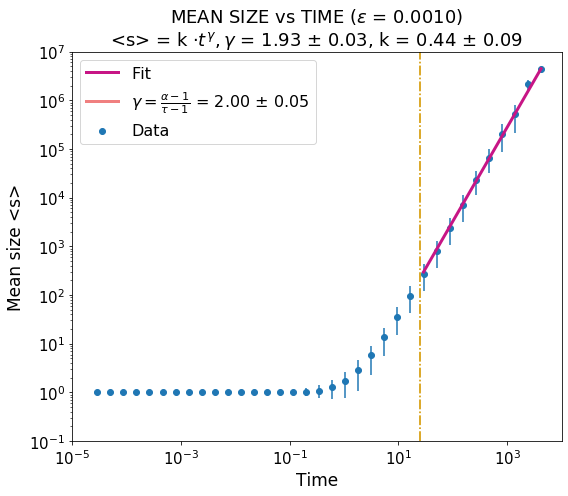

In [14]:
times = np.load("final_time_"+str(eps)+"_"+str(l)+".npy")
sizes = np.load("final_size_"+str(eps)+"_"+str(l)+".npy")


mean_s=[]
std_s=[]
for i in range(n_t_bins - 1):
    in_bin=[]
    for arg_t,t in enumerate(times):
        if t < bins_t[i+1] and t >= bins_t[i]:
            in_bin.append(arg_t)
    mean_s.append(np.mean(sizes[in_bin]))
    std_s.append(np.std(sizes[in_bin]))

    
#delete nanas    
mean_s = np.array(mean_s)
std_s=np.array(std_s)
filter_nanas = ~np.isnan(mean_s)
x_times_f = x_times[filter_nanas]
mean_s = mean_s[filter_nanas]
std_s = std_s[filter_nanas]


fig, ax = plt.subplots(1,1, figsize=(8,7))  

#cut first part of the distribution
ax.scatter(x_times_f, mean_s, marker ="o", label="Data")
ax.errorbar(x_times_f, mean_s, yerr=std_s, linestyle="None")
cut=25
ax.axvline(cut, color="goldenrod", linestyle="-.")
ax.axvline(cut, color="goldenrod", linestyle="-.")
filter_brutti = np.argwhere(x_times_f > cut).flatten()
x_times_f = x_times_f[filter_brutti]
mean_s = mean_s[filter_brutti]
std_s = std_s[filter_brutti]

#fit
(k, gamma), pcov = curve_fit(my_pareto, x_times_f, mean_s, p0=(1, 2), sigma=std_s)

th_gamma, th_d_gamma = cnr(alpha, dalpha, tau, dtau )

ax.plot(x_times_f, my_pareto(x_times_f, k, gamma), color="mediumvioletred", linewidth=3, label="Fit")
ax.plot(x_times_f, my_pareto(x_times_f, k, th_gamma), color="lightcoral", linewidth=3, 
                             label=r"$\gamma = \frac{\alpha - 1}{\tau -1}$ = %.2f $\pm$ %.2f"%(th_gamma, th_d_gamma))

ax.set_xlabel("Time", fontsize=17)
ax.set_ylabel("Mean size <s>", fontsize=17)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(10**(-1),10**7)
ax.set_xlim(10**(-5),10**4)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=16)
ax.set_title("MEAN SIZE vs TIME ($\epsilon$ = %.4f)\n" %eps + r"<s> = k $\cdot t^\gamma, \gamma$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %( -gamma, np.sqrt(pcov[1][1]), k, np.sqrt(pcov[0][0])), fontsize=18)
fig.tight_layout()


In [15]:
print("Perason correlation coeffcient: %.3f"%pearsonr(np.log10(x_times_f), np.log10(mean_s))[0])

Perason correlation coeffcient: 1.000


## $\epsilon$ = 0.01

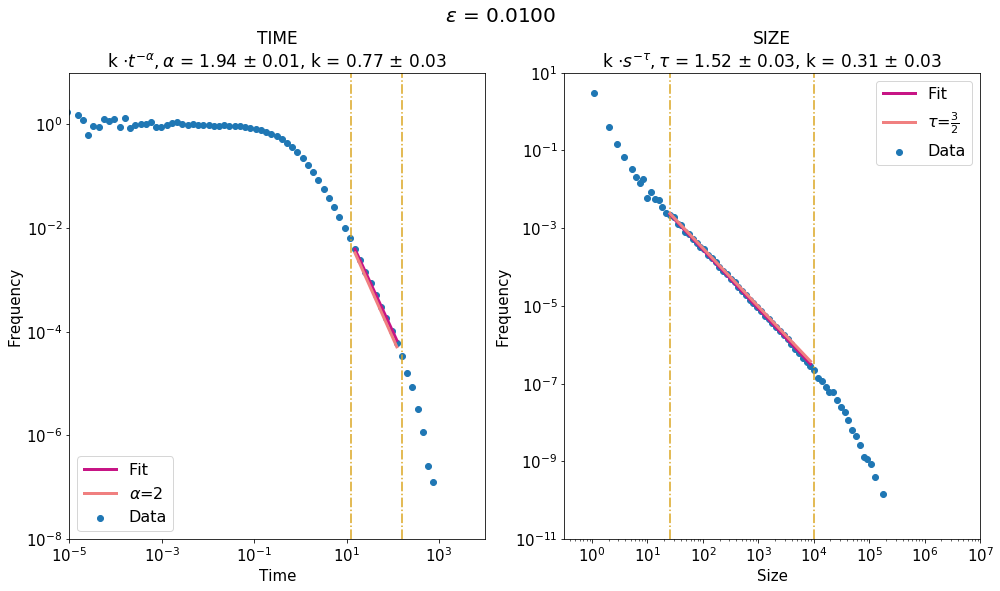

In [16]:
eps = 0.01


sizes = np.load("final_size_"+str(eps)+"_"+str(l)+".npy")
sizes.sort()
times = np.load("final_time_"+str(eps)+"_"+str(l)+".npy")
times.sort()

n_t_bins = optimal_n(times) #<------PARAMETER
threshold_t = 10**1.1 
upper_t = 10**2.2#<------PARAMETER
n_s_bins = optimal_n(sizes)  #<------PARAMETER
threshold_s = 10**1.4 #<------PARAMETER
upper_s = 10**4


fig, (ax1, ax) = plt.subplots(1,2, figsize=(14,8))
fig.suptitle(r"$\epsilon$ = %.4f"%(eps), y=1.02, fontsize=20)

#TIMES

#binning
bins_t = np.logspace(np.log10(np.min(times)),np.log10(np.max(times+1)),n_t_bins)

#compute NORMALIZED binning error as ~ sqrt(counts)/nom_cost with norm_cos= sum(counts*bin_width)
y_times, bins_t = np.histogram(times, bins=bins_t)
bin_widths = [bins_t[i+1]-bins_t[i] for i in range(len(bins_t)-1)]
y_times_err = np.sqrt(y_times)/np.sum(y_times*bin_widths)

y_times, bins_t = np.histogram(times, bins=bins_t, density=True)
x_times = [bins_t[i]+0.5*(bins_t[i+1]-bins_t[i]) for i in range(len(bins_t)-1)]
x_times=np.array(x_times)

#plot data
ax1.scatter(x_times, y_times, marker ="o", label="Data")
#ax1.errorbar(x_times, y_times, y_times_err, linestyle="None")
ax1.axvline(x=threshold_t, color="goldenrod", linestyle="-.")
ax1.axvline(x=upper_t, color="goldenrod", linestyle="-.")

#filter data to be fitted and fit

filter_t = np.argwhere(x_times > threshold_t).flatten()
x_times_f = x_times[filter_t]
y_times_f = y_times[filter_t]
y_times_err = y_times_err[filter_t]
filter_t = np.argwhere(x_times_f < upper_t).flatten()
x_times_f = x_times_f[filter_t]
y_times_f = y_times_f[filter_t]
y_times_err = y_times_err[filter_t]
(k_t, alpha), pcov_t = curve_fit(my_pareto, x_times_f, y_times_f, p0=(1, 2), sigma=y_times_err)
dalpha = np.sqrt(pcov_t[1][1])

#plot result of the fit
ax1.plot(x_times_f, my_pareto(x_times_f, k_t, alpha), color="mediumvioletred", linewidth=3, label="Fit")
ax1.plot(x_times_f, my_pareto(x_times_f, k_t, 2), color="lightcoral", linewidth=3, label=r"$\alpha$=2")
ax1.set_xlabel("Time", fontsize=15)
ax1.set_ylabel("Frequency", fontsize=15)
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylim(10**(-8),10**1)
ax1.set_xlim(10**(-5), 10**4)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_title("TIME\n"+r"k $\cdot t^{-\alpha}, \alpha$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %(alpha, dalpha, k_t, np.sqrt(pcov_t[0][0])), fontsize=17)
ax1.legend(fontsize=16)



#SIZES

bins_s = np.logspace(np.log10(np.min(sizes)),np.log10(np.max(sizes+1)),n_s_bins)
#compute binning errors
y_sizes, bins_s = np.histogram(sizes, bins=bins_s)
bin_widths = [bins_s[i+1]-bins_s[i] for i in range(len(bins_s)-1)]
y_sizes_err = np.sqrt(y_sizes)/np.sum(y_sizes*bin_widths)

#binning
y_sizes, bins_s = np.histogram(sizes, bins=bins_s, density=True)
x_sizes = [bins_s[i]+0.5*(bins_s[i+1]-bins_s[i]) for i in range(len(bins_s)-1)]
x_sizes= np.array(x_sizes)

#plot data
ax.scatter(x_sizes, y_sizes, marker ="o", label="Data")
#ax.errorbar(x_sizes, y_sizes, y_sizes_err, linestyle="None")
ax.axvline(x=threshold_s, color="goldenrod", linestyle="-.")
ax.axvline(x=upper_s, color="goldenrod", linestyle="-.")

#filter data to be fitted and fit
#filter data to be fitted and fit
filter_s = np.argwhere(x_sizes > threshold_s).flatten()
x_sizes_f = x_sizes[filter_s]
y_sizes_f = y_sizes[filter_s]
y_sizes_err = y_sizes_err[filter_s]
filter_s = np.argwhere(x_sizes_f < upper_s).flatten()
x_sizes_f = x_sizes_f[filter_s]
y_sizes_f = y_sizes_f[filter_s]
y_sizes_err = y_sizes_err[filter_s]

(k_s, tau), pcov_s = curve_fit(my_pareto, x_sizes_f, y_sizes_f, sigma=y_sizes_err, p0=(1, 1.5))
dtau = np.sqrt(pcov_s[1][1])
#plot result of the fit
ax.plot(x_sizes_f, my_pareto(x_sizes_f, k_s, tau), color="mediumvioletred", linewidth=3, label="Fit")
ax.plot(x_sizes_f, my_pareto(x_sizes_f, k_s, 1.5), color="lightcoral", linewidth=3, label=r"$\tau$=$\frac{3}{2}$")
ax.set_xlabel("Size", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(10**(-11),10**1)
ax.set_xlim(10**(-0.5),10**7)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title("SIZE\n"+r"k $\cdot s^{-\tau}, \tau$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %(tau, dtau, k_s, np.sqrt(pcov_s[0][0])), fontsize=17)
ax.legend(fontsize=16)



fig.tight_layout()



In [17]:
(_, alpha_lf), pcov_t = curve_fit(my_line, np.log10(x_times_f), np.log10(y_times_f), 
                               sigma=np.log10(e)*y_times_err/y_times_f, p0=(1, 2))
print("Result of linear fit: alpha = %.4f \pm %.4f" %(alpha_lf, pcov_t[1][1]))
print("Result of pareto fir: alpha = %.4f \pm %.4f" %(alpha, dalpha))

(_, tau_lf), pcov_s = curve_fit(my_line, np.log10(x_sizes_f), np.log10(y_sizes_f), 
                               sigma=np.log10(e)*y_sizes_err/y_sizes_f, p0=(1, 1.5))
print("Result of linear fit: tau = %.4f \pm %.4f" %(tau_lf, pcov_t[1][1]))
print("Result of pareto fit: tau = %.4f \pm %.4f" %(tau, dtau))

Result of linear fit: alpha = 1.9379 \pm 0.0002
Result of pareto fir: alpha = 1.9396 \pm 0.0142
Result of linear fit: tau = 1.5154 \pm 0.0002
Result of pareto fit: tau = 1.5177 \pm 0.0278


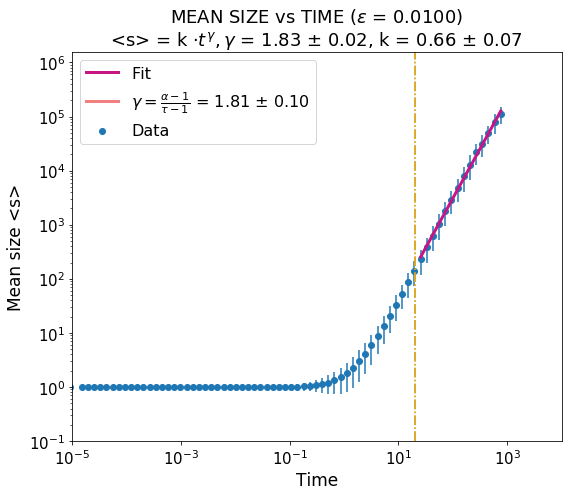

In [18]:
times = np.load("final_time_"+str(eps)+"_"+str(l)+".npy")
sizes = np.load("final_size_"+str(eps)+"_"+str(l)+".npy")
#times = times[times > threshold_t]
#times = times[times < upper_t]

mean_s=[]
std_s=[]
for i in range(n_t_bins - 1):
    in_bin=[]
    for arg_t,t in enumerate(times):
        if t < bins_t[i+1] and t >= bins_t[i]:
            in_bin.append(arg_t)
    mean_s.append(np.mean(sizes[in_bin]))
    std_s.append(np.std(sizes[in_bin]))

    
#delete nanas    
mean_s = np.array(mean_s)
std_s=np.array(std_s)
filter_nanas = ~np.isnan(mean_s)
x_times_f = x_times[filter_nanas]
mean_s = mean_s[filter_nanas]
std_s = std_s[filter_nanas]


fig, ax = plt.subplots(1,1, figsize=(8,7))  

#cut first part of the distribution
ax.scatter(x_times_f, mean_s, marker ="o", label="Data")
ax.errorbar(x_times_f, mean_s, yerr=std_s, linestyle="None")
cut=20
ax.axvline(cut, color="goldenrod", linestyle="-.")
ax.axvline(cut, color="goldenrod", linestyle="-.")
filter_brutti = np.argwhere(x_times_f > cut).flatten()
x_times_f = x_times_f[filter_brutti]
mean_s = mean_s[filter_brutti]
std_s = std_s[filter_brutti]

#fit
(k, gamma), pcov = curve_fit(my_pareto, x_times_f, mean_s, p0=(1, 2), sigma=std_s)

th_gamma, th_d_gamma = cnr(alpha, dalpha, tau, dtau )

ax.plot(x_times_f, my_pareto(x_times_f, k, gamma), color="mediumvioletred", linewidth=3, label="Fit")
ax.plot(x_times_f, my_pareto(x_times_f, k, th_gamma), color="lightcoral", linewidth=3, 
                             label=r"$\gamma = \frac{\alpha -1}{\tau -1}$ = %.2f $\pm$ %.2f"%(th_gamma, th_d_gamma))

ax.set_xlabel("Time", fontsize=17)
ax.set_ylabel("Mean size <s>", fontsize=17)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(10**(-1),10**6.2)
ax.set_xlim(10**(-5),10**4)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=16)
ax.set_title("MEAN SIZE vs TIME ($\epsilon$ = %.4f)\n" %eps + r"<s> = k $\cdot t^\gamma, \gamma$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %( -gamma, np.sqrt(pcov[1][1]), k, np.sqrt(pcov[0][0])), fontsize=18)

fig.tight_layout()


In [19]:
print("Perason correlation coeffcient: %.3f"%pearsonr(np.log10(x_times_f), np.log10(mean_s))[0])

Perason correlation coeffcient: 0.999
